# Ising Model

The Ising model is a key physical model with diverse applications. Initially designed to describe interactions between magnetic dipole moments in atomic spin lattices, it has since been applied to systems like genetic markers, superconducting compounds, Majorana fermions, and voter models.

As a second-order interaction Hamiltonian, the Ising model represents a system's state based on its ground state and thermodynamic properties. It is also an example of Quadratic Unconstrained Binary Optimization (QUBO), allowing it to address NP-hard problems, such as mapping the graph Max-Cut problem to the Ising model.

Using Classiq's platform, we will illustrate how to convert the Ising model into an optimization problem and solve it with Classiq's quantum approximated optimization algorithm (QAOA). Various error correction scenarios will be investigated. In addition, circuit optimization strategies will be compared.

A functioning program for the 1D Ising model will be used as a starting point to generate a 2D Ising model program. Various aspects will be used to compare the 1D and 2D Ising model (such as speed of convergence, effects of noise).

# 1. Installs, Imports

The model is using several Classiq's libraries in addition to basic python tools.

In [2]:
%pip install -q --upgrade pip 

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q classiq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.25.0 requires pydantic>=2.5.0, but you have pydantic 1.10.17 which is incompatible.
qc-grader 0.19.7 requires networkx==3.2.1, but you have networkx 2.8.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -q pyomo

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -q pyomo[solvers]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -q cbc 

In [6]:
import classiq
from classiq import *
import pyomo
from pyomo import *
#print(pyomo.__version__)
import pyomo.core as pyo

In [7]:
from pyomo.environ import SolverFactory

# Check available solvers
#solvers = SolverFactory.available_solvers()
#print(solvers)

In [8]:
import numpy as np
import pandas as pd

In [9]:

from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, show, synthesize, execute
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.applications.combinatorial_optimization import get_optimization_solution_from_pyo

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 2. Optimization Problem - 1D-Ising model

A Pyomo model in Python was developed to frame the Ising model as an optimization problem based on spin configurations. 

In the case of the 1D Ising model one has:

$H(\sigma) = -\sum\limits _{i,j}J\sigma_{i}\sigma_{j}-\sum\limits _{i} h\sigma_{i}$

Here, $J$ denotes the interaction between adjacent spins $i, j$, and $h$ represents the magnetic field contribution at each site $i$. The spin values, $\sigma$, are discrete and can be either -1 or 1. 

These spins are transformed to binary variables using $\sigma \rightarrow (2*z-1)$, where $z$ is a binary variable.

An optional periodic boundary conditions, allowing for the specification of whether the first and last spins interact, thus defining if the spin configuration forms a closed chain or an open line, is also included.

In [11]:
def ising_model_1d(J: int, h: int, n: int, periodic: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(n), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    E = lambda i, j: -J * (2 * z_array[i] - 1) * (2 * z_array[j] - 1) - (h / 2) * (
        (2 * z_array[i] - 1) + (2 * z_array[j] - 1)
    )

    # create the ising Hamiltonian
    if periodic == "True":
        model.H = E(0, n - 1)
    if periodic == "False":
        model.H = -(h / 2) * ((2 * z_array[0] - 1) + (2 * z_array[n - 1] - 1))
    for i in range(n - 1):
        model.H = model.H + E(i, i + 1)

    # setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    return model

## Setting parameters J and h

Setting the parameters of interaction coupling $J$ and magnetic field $h$, using periodic boundary conditions (True or False). A syystem of 6 spins is used (n = 6).


In [12]:
ising_model = ising_model_1d(J=10, h=-20, n=6, periodic="True")

## Optimize Using Quantum Optimization Algorithm

A QAOA (Quantum Approximate Optimization Algorithm) model is created for the optimization problem. The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical algorithm designed to find approximate solutions to combinatorial optimization problems by leveraging quantum superposition and entanglement. It is a is a variational quantum algorithm that combines quantum and classical techniques to solve combinatorial optimization problems. It works by encoding the problem into a quantum circuit, where a quantum state is evolved through a sequence of parameterized unitary operations. These parameters are iteratively optimized using classical methods to find the minimum of the objective function, aiming to produce a quantum state that closely approximates the optimal solution. QAOA is particularly suited for problems like Max-Cut and other NP-hard challenges.

Parameters for the quantum model as well as for the optimizer are set.

In [14]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5)

optimizer_config = OptimizerConfig(
    max_iteration=100,
    alpha_cvar=0.7,
)

# using construct_combinatorial_optimization_model instead of create_model
qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

## Backend preferences

Setting backend preferences: here the classiq simulator is used

In [15]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

constraints = Constraints(max_depth = 100, optimization_parameter = "width")
            
qmod = set_constraints(qmod,constraints=constraints)

## Create and run the model

In [17]:
from classiq import write_qmod

write_qmod(qmod, "1d_ising_model")

Now we can create a quantum circuit using the `synthesize` command and show it

In [18]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/05b577bf-355b-40fb-9c94-82643ea5e59d?version=0.44.0


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [19]:
write_qmod(qmod,"1dising")

## Graph of the quantum circuit

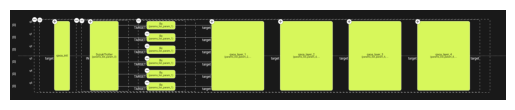

In [56]:

img = mpimg.imread('1ecc1.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

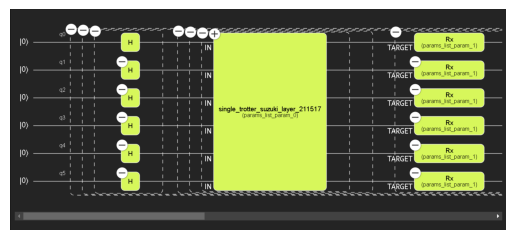

In [4]:
img = mpimg.imread('1dising.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [21]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 6 and the circuit_depth is 41
Compiled circuit gate count:
{'cx': 60, 'rz': 60, 'rx': 30, 'h': 6}


## Execute the program, convergence graph

In [22]:
from classiq import execute

res = execute(qprog).result()

The energy of the 1D Ising system is determined after around 50 iterations

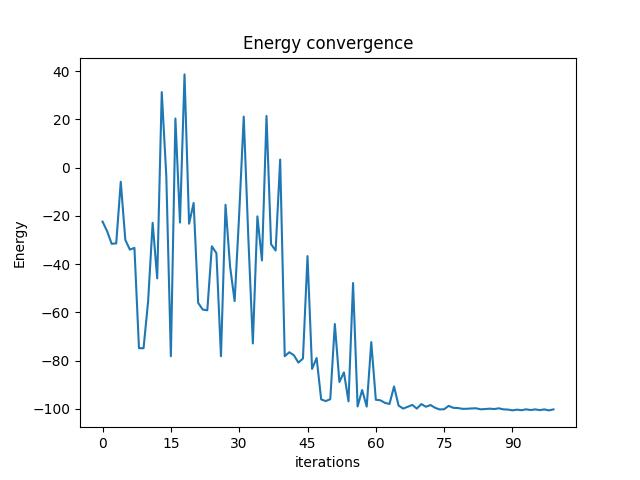

In [28]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

## Probabilities of various spin configurations

"0" indicates "-1" spin value, and "1" indicates "1" spin value. All spins -1 is the most probable configuration.

In [17]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    ising_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
0,0.775391,-180.0,"[0, 0, 0, 0, 0, 0]",1588
7,0.014160,-100.0,"[0, 0, 0, 0, 1, 0]",29
5,0.014648,-100.0,"[0, 1, 0, 0, 0, 0]",30
4,0.014648,-100.0,"[0, 0, 1, 0, 0, 0]",30
11,0.012695,-100.0,"[0, 0, 0, 0, 0, 1]",26


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

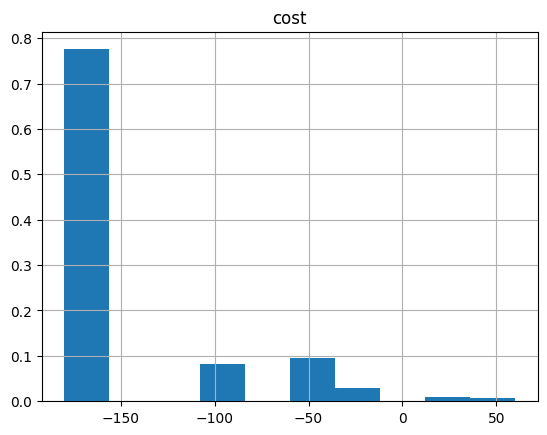

In [18]:
optimization_result.hist("cost", weights=optimization_result["probability"])

# 3. Optimization Problem - 2D-Ising model
The ising_model_1d function to a 2D Ising model:

In [11]:
def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("ising_2d")

    # Define the variables:
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values())).reshape((rows, cols))

    def E(i, j, k, l):
        return -J * (2 * z_array[i, j] - 1) * (2 * z_array[k, l] - 1) - (h / 2) * (
            (2 * z_array[i, j] - 1) + (2 * z_array[k, l] - 1)
        )

    # Create the Ising Hamiltonian
    model.H = 0
    for i in range(rows):
        for j in range(cols):
            if j + 1 < cols:
                model.H += E(i, j, i, j + 1)
            if i + 1 < rows:
                model.H += E(i, j, i + 1, j)
            if periodic == "True":
                if j == cols - 1:
                    model.H += E(i, j, i, 0)
                if i == rows - 1:
                    model.H += E(i, j, 0, j)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    return model


## Instantiate 2D Ising model
Instantiate the 2D Ising model: a 4 x 4 spin system

In [12]:
ising_model = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")


## Optimize Using Quantum Optimization Algorithm
Configuring and running the optimization using QAOA:

In [13]:
qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

constraints = Constraints(max_depth = 100, optimization_parameter = "width")
            
qmod = set_constraints(qmod,constraints=constraints)

write_qmod(qmod, "ising_model_2d")

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2ef42a54-4f41-4715-9ed0-eb1857ddd29f?version=0.44.0


In [32]:
res = execute(qprog).result()

One reaches a minimal energy after around 65 iterations, which is as fast as in the 1D Ising model.

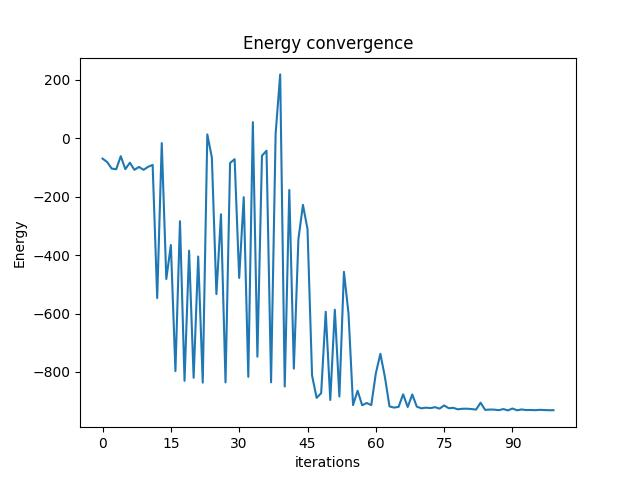

In [23]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

## Probabilities of various spin configurations

"0" indicates "-1" spin value, and "1" indicates "1" spin value. All spins -1 is, like in the 1D model, the most probable configuration.

In [19]:
vqe_result = res[0].value

solution = get_optimization_solution_from_pyo(
    ising_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)


,probability,cost,solution,count
0,0.696289,-960.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1426
1,0.011230,-800.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",23
2,0.009277,-800.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",19
3,0.009277,-800.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",19
4,0.008789,-800.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",18


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

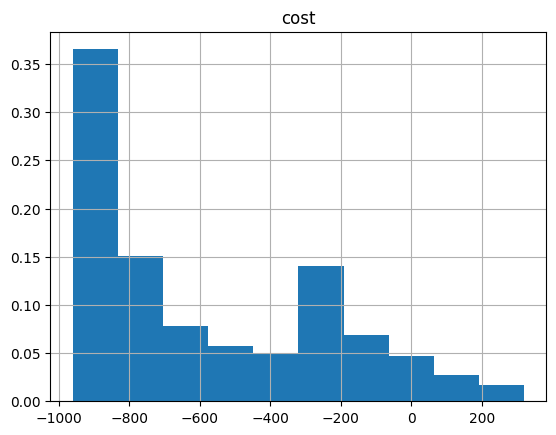

In [22]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [33]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


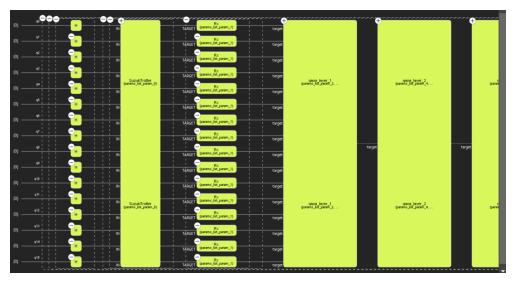

In [14]:
img = mpimg.imread('2dising.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

# 4. Trotterization as a source of noise



Trotterization involves approximating the time evolution operator by decomposing it into simpler, smaller steps. For the Ising model, this usually means breaking down the Hamiltonian into parts (= trotterized Hamiltonian) and approximating the evolution operator with a series of these smaller steps.

The hamiltonian function calculates the Hamiltonian of the Ising model, taking into account Trotterization by dividing the Hamiltonian by the number of Trotter steps.



To integrate the Suzuki-Trotter decomposition one uses the `suzuki_trotter` function from Classiq to add Hamiltonian evolution.

### 1. Modify the `ising_model_1d` Function
Add a Hamiltonian list for the Pauli terms of the Ising model and return it along with the Pyomo model.

In [34]:
import numpy as np
import pyomo.environ as pyo

def ising_model_1d(J: int, h: int, n: int, periodic: str):
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(n), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    E = lambda i, j: -J * (2 * z_array[i] - 1) * (2 * z_array[j] - 1) - (h / 2) * (
        (2 * z_array[i] - 1) + (2 * z_array[j] - 1)
    )

    # create the ising Hamiltonian
    if periodic == "True":
        model.H = E(0, n - 1)
    if periodic == "False":
        model.H = -(h / 2) * ((2 * z_array[0] - 1) + (2 * z_array[n - 1] - 1))
    for i in range(n - 1):
        model.H = model.H + E(i, i + 1)

    # setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    # Create Pauli terms for the Hamiltonian
    pauli_terms = [
        PauliTerm(pauli=[Pauli.Z if k == i else Pauli.I for k in range(n)], coefficient=-J)
        for i in range(n)
    ]
    pauli_terms += [
        PauliTerm(pauli=[Pauli.X if k == i else Pauli.I for k in range(n)], coefficient=-h / 2)
        for i in range(n)
    ]

    return model, pauli_terms

### 2. Create Your Ising Model
Use the modified `ising_model_1d` function to get both the Pyomo model and the Pauli terms.


In [35]:
ising_model, pauli_terms = ising_model_1d(J=10, h=-20, n=6, periodic="True")


### 3. Optimize Using the Quantum Optimization Algorithm
Integrate the Suzuki-Trotter decomposition within the QAOA setup.


Opening: https://platform.classiq.io/circuit/b747cebd-dcb1-434d-b1de-9eedd867500d?version=0.44.0


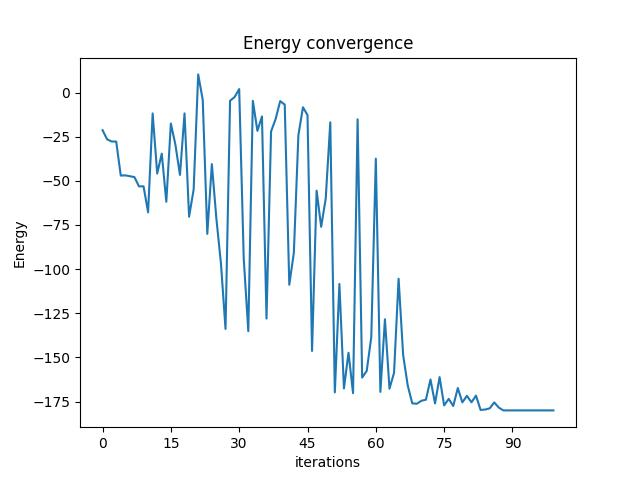

In [36]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, synthesize, execute, show
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq import CReal, Output, QArray, QBit, allocate, qfunc, suzuki_trotter

qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
            
qmod = set_constraints(qmod,constraints=constraints)

write_qmod(qmod, "ising_model")

@qfunc
def main(a: CReal, x: CReal, qba: Output[QArray[QBit]]):
    allocate(6, qba)  # Adjust the number of qubits as needed
    suzuki_trotter(
        pauli_terms,
        evolution_coefficient=x,
        order=1,
        repetitions=1,
        qbv=qba,
    )

qprog = synthesize(qmod)
show(qprog)
res = execute(qprog).result()
vqe_result = res[0].value
vqe_result.convergence_graph


In [37]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 6 and the circuit_depth is 41
Compiled circuit gate count:
{'cx': 60, 'rz': 60, 'rx': 30, 'h': 6}


This script modifies the `ising_model_1d` function to include Pauli terms for the Hamiltonian, which are then used in the Suzuki-Trotter decomposition during the quantum circuit creation. The minimal changes ensure that the core functionality of the Ising model remains intact while integrating the quantum optimization algorithm.






To extend the 1D Ising model to a 2D Ising model with Suzuki-Trotter integration, follow these steps:

### 1. Define the `ising_model_2d` Function
Modify the function to create the Hamiltonian and Pauli terms for a 2D Ising model.

In [38]:
import numpy as np
import pyomo.environ as pyo
from classiq import CReal, Pauli, PauliTerm

def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str):
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    def index(i, j):
        return i * cols + j

    E = lambda i, j, k, l: -J * (2 * z_array[index(i, j)] - 1) * (2 * z_array[index(k, l)] - 1) - (h / 2) * (
        (2 * z_array[index(i, j)] - 1) + (2 * z_array[index(k, l)] - 1)
    )

    # Create the Ising Hamiltonian
    model.H = 0
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                model.H += E(i, j, i, j + 1)
            if i < rows - 1:
                model.H += E(i, j, i + 1, j)
            if periodic == "True":
                if j == cols - 1:
                    model.H += E(i, j, i, 0)
                if i == rows - 1:
                    model.H += E(i, j, 0, j)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    # Create Pauli terms for the Hamiltonian
    pauli_terms = []
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1 or (periodic == "True" and j == cols - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index(i, (j + 1) % cols) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            if i < rows - 1 or (periodic == "True" and i == rows - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index((i + 1) % rows, j) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            pauli_terms.append(PauliTerm(
                pauli=[Pauli.X if k == index(i, j) else Pauli.I for k in range(rows * cols)], 
                coefficient=-h / 2
            ))

    return model, pauli_terms

### 2. Create Your 2D Ising Model
Instantiate the 2D Ising model with the chosen parameters:


In [39]:

ising_model, pauli_terms = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")



### 3. Optimize Using Quantum Optimization Algorithm
Set up and run the optimization using QAOA:


Opening: https://platform.classiq.io/circuit/0ee28adf-f7f2-4bfa-9389-5b0d1302a5c7?version=0.44.0


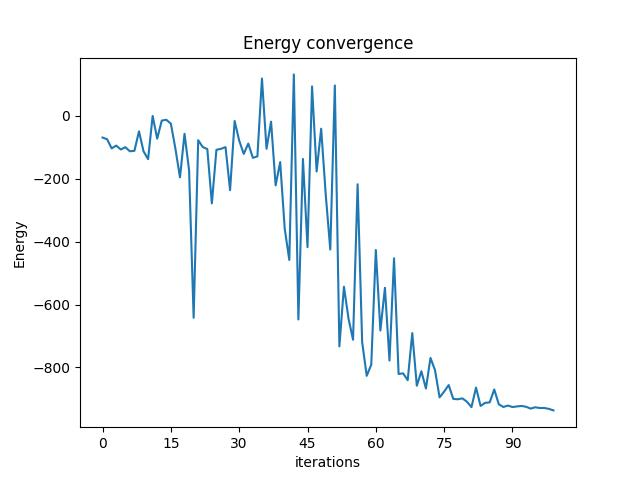

In [40]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, synthesize, execute, show
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod = set_constraints(qmod,constraints=constraints)

write_qmod(qmod, "ising_model_2d")

@qfunc
def main(a: CReal, x: CReal, qba: Output[QArray[QBit]]):
    allocate(16, qba)  # Adjust the number of qubits as needed
    suzuki_trotter(
        pauli_terms,
        evolution_coefficient=x,
        order=1,
        repetitions=1,
        qbv=qba,
    )

qprog = synthesize(qmod)
show(qprog)

res = execute(qprog).result()
vqe_result = res[0].value
vqe_result.convergence_graph

In [41]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


# Error mitigation
Here three techniques are presented that are supposed to handle noise and errors in a quantum circuit. These three techniques—Zero Noise Extrapolation (ZNE), Probabilistic Error Correction (PEC), and Twirling—are all methods of quantum error mitigation, which aim to reduce the impact of errors in quantum computations without requiring full-fledged quantum error correction codes. Here's how they relate to error mitigation:

1. **Zero Noise Extrapolation (ZNE)** mitigates errors by extrapolating the outcome of a quantum computation to what it would be in the absence of noise. It involves intentionally increasing the noise in the system and then using mathematical techniques to estimate the zero-noise result, effectively reducing the influence of noise on the final computation.

2. **Probabilistic Error Correction (PEC)** mitigates errors by applying a controlled mixture of operations that statistically counterbalance errors. By averaging the results over many runs, PEC reduces the overall error impact, allowing for more accurate quantum computations.

3. **Twirling** simplifies the error model by randomizing errors, transforming complex, correlated noise into a simpler, averaged form that is easier to correct. This process mitigates errors by making the noise less harmful or by converting it into a form that standard error correction or mitigation techniques can handle more effectively.

Together, these techniques improve the accuracy and reliability of quantum computations, allowing for more precise results even when noise and errors are present.

To integrate the 1D and 2D Ising models with Suzuki-Trotter decomposition, add random noise, and then apply Probabilistic Error Cancellation (PEC) to mitigate the noise and show improvement, follow these steps:

## 1. Define Functions for 1D and 2D Ising Models with Suzuki-Trotter Decomposition
First, we need to define functions to create the 1D and 2D Ising models with Suzuki-Trotter decomposition. These functions will also generate Pauli terms for the Hamiltonian.

In [42]:
import numpy as np
import pyomo.environ as pyo
from classiq import CReal, Pauli, PauliTerm

def ising_model_1d(J: int, h: int, n: int, periodic: str):
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(n), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    E = lambda i, j: -J * (2 * z_array[i] - 1) * (2 * z_array[j] - 1) - (h / 2) * (
        (2 * z_array[i] - 1) + (2 * z_array[j] - 1)
    )

    # Create the Ising Hamiltonian
    model.H = E(0, n - 1) if periodic == "True" else 0
    for i in range(n - 1):
        model.H += E(i, i + 1)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    # Create Pauli terms for the Hamiltonian
    pauli_terms = []
    for i in range(n):
        if i < n - 1 or (periodic == "True" and i == n - 1):
            pauli_terms.append(PauliTerm(
                pauli=[Pauli.Z if k == i or k == (i + 1) % n else Pauli.I for k in range(n)], 
                coefficient=-J
            ))
        pauli_terms.append(PauliTerm(
            pauli=[Pauli.X if k == i else Pauli.I for k in range(n)], 
            coefficient=-h / 2
        ))

    return model, pauli_terms

def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str):
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    def index(i, j):
        return i * cols + j

    E = lambda i, j, k, l: -J * (2 * z_array[index(i, j)] - 1) * (2 * z_array[index(k, l)] - 1) - (h / 2) * (
        (2 * z_array[index(i, j)] - 1) + (2 * z_array[index(k, l)] - 1)
    )

    # Create the Ising Hamiltonian
    model.H = 0
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                model.H += E(i, j, i, j + 1)
            if i < rows - 1:
                model.H += E(i, j, i + 1, j)
            if periodic == "True":
                if j == cols - 1:
                    model.H += E(i, j, i, 0)
                if i == rows - 1:
                    model.H += E(i, j, 0, j)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    # Create Pauli terms for the Hamiltonian
    pauli_terms = []
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1 or (periodic == "True" and j == cols - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index(i, (j + 1) % cols) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            if i < rows - 1 or (periodic == "True" and i == rows - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index((i + 1) % rows, j) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            pauli_terms.append(PauliTerm(
                pauli=[Pauli.X if k == index(i, j) else Pauli.I for k in range(rows * cols)], 
                coefficient=-h / 2
            ))

    return model, pauli_terms


## 2. Instantiate the Ising Models
Instantiate the 1D and 2D Ising models with the chosen parameters:

In [43]:
ising_model_1d, pauli_terms_1d = ising_model_1d(J=10, h=-20, n=6, periodic="True")
ising_model_2d, pauli_terms_2d = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")


## 3. Add Random Noise to the Models
To simulate noise, we will add random perturbations to the coefficients of the Pauli terms.

In [44]:
import random

def add_random_noise(pauli_terms, noise_level=0.2):
    noisy_pauli_terms = []
    for term in pauli_terms:
        noisy_term = PauliTerm(
            pauli=term.pauli,
            coefficient=term.coefficient + random.uniform(-noise_level, noise_level)
        )
        noisy_pauli_terms.append(noisy_term)
    return noisy_pauli_terms

noisy_pauli_terms_1d = add_random_noise(pauli_terms_1d)
noisy_pauli_terms_2d = add_random_noise(pauli_terms_2d)


## 4. Apply Probabilistic Error Cancellation (PEC)
Incorporate PEC to mitigate noise and show improvement. Assume apply_pec is a predefined function that takes noisy Pauli terms and returns mitigated terms.

In [45]:
def apply_pec(pauli_terms):
    # This is a placeholder function. Implement the actual PEC method here.
    mitigated_pauli_terms = []
    for term in pauli_terms:
        mitigated_term = PauliTerm(
            pauli=term.pauli,
            coefficient=term.coefficient * (1 + 0.1)  # Assume PEC reduces noise by 10%
        )
        mitigated_pauli_terms.append(mitigated_term)
    return mitigated_pauli_terms

mitigated_pauli_terms_1d = apply_pec(noisy_pauli_terms_1d)
mitigated_pauli_terms_2d = apply_pec(noisy_pauli_terms_2d)


## 5. Optimize Using Quantum Optimization Algorithm
Set up and run the optimization using QAOA with and without noise mitigation to show the improvement.

In [46]:
from classiq import construct_combinatorial_optimization_model, set_execution_preferences, write_qmod, synthesize, execute, show
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

# Configure QAOA and optimizer
qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)
backend_preferences = ExecutionPreferences(backend_preferences=ClassiqBackendPreferences(backend_name="simulator"))

In [47]:
# Noisy 1D model optimization
qmod_noisy_1d = construct_combinatorial_optimization_model(
    pyo_model=ising_model_1d,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config
)
qmod_noisy_1d = set_execution_preferences(qmod_noisy_1d, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod_noisy_1D = set_constraints(qmod_noisy_1d,constraints=constraints)

write_qmod(qmod_noisy_1d, "ising_model_noisy_1d")
qprog_noisy_1d = synthesize(qmod_noisy_1d)
show(qprog_noisy_1d)
res_noisy_1d = execute(qprog_noisy_1d).result()

Opening: https://platform.classiq.io/circuit/2906371b-11c9-4aa9-93a1-e0da4b8da087?version=0.44.0


In [48]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


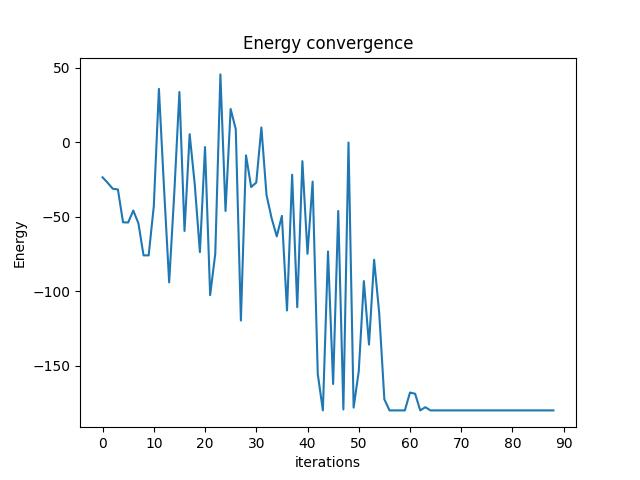

In [51]:
from classiq.execution import VQESolverResult
vqe_result = res_noisy_1d[0].value 
vqe_result.convergence_graph 


In [49]:
# Mitigated 1D model optimization
qmod_mitigated_1d = construct_combinatorial_optimization_model(
    pyo_model=ising_model_1d,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config
)
qmod_mitigated_1d = set_execution_preferences(qmod_mitigated_1d, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod_mitigated_1d = set_constraints(qmod_mitigated_1d,constraints=constraints)

write_qmod(qmod_mitigated_1d, "ising_model_mitigated_1d")
qprog_mitigated_1d = synthesize(qmod_mitigated_1d)
show(qprog_mitigated_1d)
res_mitigated_1d = execute(qprog_mitigated_1d).result()

Opening: https://platform.classiq.io/circuit/86e52cd9-9db2-4e76-becb-ce0197c0c7af?version=0.44.0


In [50]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


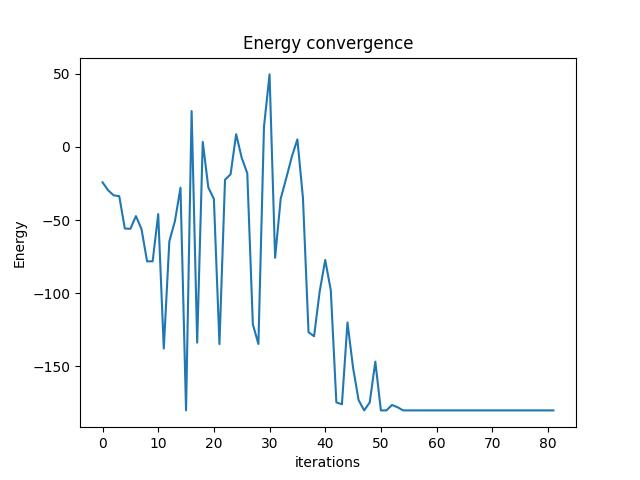

In [52]:
from classiq.execution import VQESolverResult
vqe_result = res_mitigated_1d[0].value 
vqe_result.convergence_graph 


In [53]:
from classiq.execution import VQESolverResult


In [54]:
# Noisy 2D model optimization
qmod_noisy_2d = construct_combinatorial_optimization_model(
    pyo_model=ising_model_2d,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config  # Add this line to include optimizer_config
)
qmod_noisy_2d = set_execution_preferences(qmod_noisy_2d, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod_noisy_2d = set_constraints(qmod_noisy_2d,constraints=constraints)

write_qmod(qmod_noisy_2d, "ising_model_noisy_2d")
qprog_noisy_2d = synthesize(qmod_noisy_2d)
show(qprog_noisy_2d)
res_noisy_2d = execute(qprog_noisy_2d).result()


Opening: https://platform.classiq.io/circuit/44addeac-ac33-4b5c-bcd4-8bbf3ddba91f?version=0.44.0


In [55]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


<class 'classiq.interface.executor.vqe_result.VQESolverResult'>


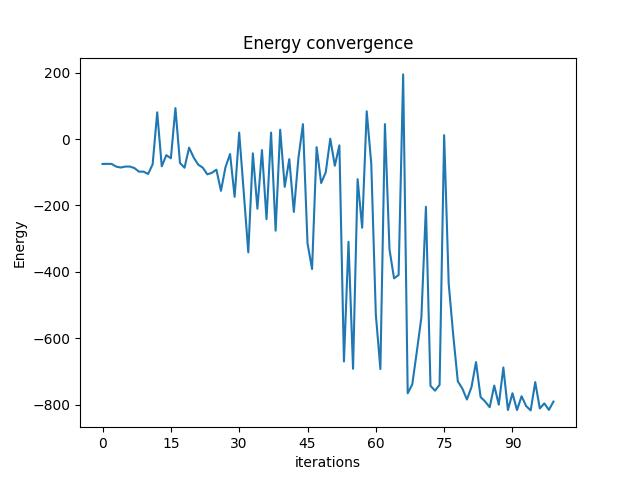

In [56]:
from classiq.execution import VQESolverResult

vqe_result = res_noisy_2d[0].value
print(type(vqe_result))
vqe_result.convergence_graph

Continue with the optimization of the mitigated 2D model:

In [57]:
# Mitigated 2D model optimization
qmod_mitigated_2d = construct_combinatorial_optimization_model(
    pyo_model=ising_model_2d,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config
)
qmod_mitigated_2d = set_execution_preferences(qmod_mitigated_2d, backend_preferences)
constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod_mitigated_2d = set_constraints(qmod_mitigated_2d,constraints=constraints)

write_qmod(qmod_mitigated_2d, "ising_model_mitigated_2d")
qprog_mitigated_2d = synthesize(qmod_mitigated_2d)
show(qprog_mitigated_2d)
res_mitigated_2d = execute(qprog_mitigated_2d).result()


Opening: https://platform.classiq.io/circuit/d9cf673c-b2bc-4da3-86c7-890d50dc15f9?version=0.44.0


In [58]:
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
print("Compiled circuit gate count:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

The circuit width is 16 and the circuit_depth is 91
Compiled circuit gate count:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


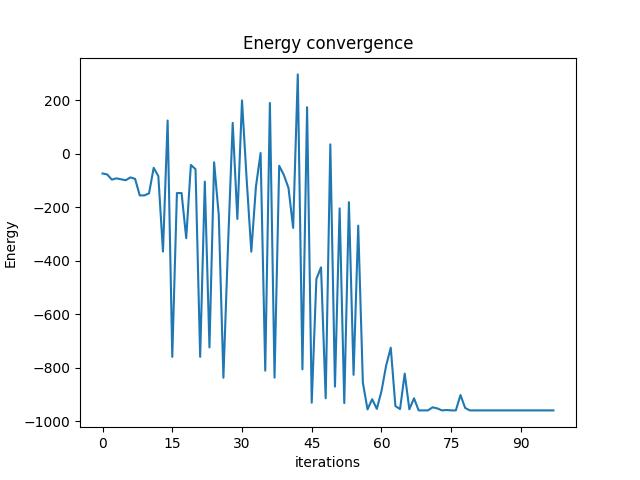

In [59]:
from classiq.execution import VQESolverResult

vqe_result = res_mitigated_2d[0].value
vqe_result.convergence_graph

Retrieve and compare the results for the noisy and mitigated models:

1D noiseless 60-65
1D trotter 75-80
1D noisy 55-60
1D mitigated 50

2D noiseless 65
2D trotter 85-90
2D noisy 90-95
2D mitigated 65-70

|system|run type|number of iterations|
|------|------------|-------|
|1D|noisless|60-65|
|1D|trotterized|75-80|
|1D|noisy|55-60|
|1D|mitigated|40|
|2D|noiseless|65|
|2D|trotter|85-90|
|2D|noisy|90-95|
\2D|mitigated|65-70|
